# tsod_detector를 활용한 anomaly 탐지
- 참고한 논문 "Time Series Anomaly Detection" (https://arxiv.org/ftp/arxiv/papers/1708/1708.03665.pdf)

- 현재 tsod 라는 module을 이용해 이상치를 탐지하는 방식이다. 방식은 여러가지가 있는 것을 확인했으며, 데이터를 통해서 예측을 하고 이상치를 tsod를 통해서 표시하는 방법의 논문으로 확인 했다.

- Discriminator 같은 것들을 이용해 직접 판별해주기 보다는 사용자가 이상치의 기준을 정해주고 그것을 감지해주는 방식으로 확인했다. (약간의 주먹구구식으로 해결하는 느낌이 강해 보인다.)

- 결론적으로는 미리 모델링한 transformer model을 통해서 예측하고, 그 결과 값중에 이상치(outlier)라고 판단 되는 기준을 설정해 anomaly를 탐지하는 식으로 적용했다.

- 만약에 이 방법을 사용하게 될 경우, 조금 더 명확한 기준을 선정하는 것이 필요해 보인다.

## 필요 module install

In [1]:
pip install tsod

In [2]:
!git clone https://github.com/numenta/NAB.git

Cloning into 'NAB'...
remote: Enumerating objects: 6932, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 6932 (delta 7), reused 9 (delta 4), pack-reused 6915
Receiving objects: 100% (6932/6932), 83.23 MiB | 13.43 MiB/s, done.
Resolving deltas: 100% (4881/4881), done.
Checking out files: 100% (1120/1120), done.


In [6]:
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/DHI/tsod/main/tests/data/example.csv', parse_dates=True, index_col=0)
data.head()

,value
datetime,
2000-01-01 00:00:00,0.000000
2000-01-01 01:00:00,1.152781
2000-01-01 02:00:00,1.450556
2000-01-01 03:00:00,0.958643
2000-01-01 04:00:00,1.174895


## Example data check

In [7]:
from sklearn.preprocessing import MinMaxScaler
import tsod
import matplotlib.pyplot as plt

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

data_scaled = data_scaled.reshape(-1)
data_scaled = pd.Series(data_scaled)
data_scaled

0      0.000000
1      0.384260
2      0.483519
3      0.319548
4      0.391632
         ...   
129    0.322968
130    0.360117
131    0.467136
132    0.480552
133    0.581726
Length: 134, dtype: float64

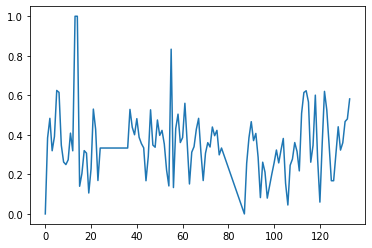

In [8]:
y = data_scaled
plt.plot(y)

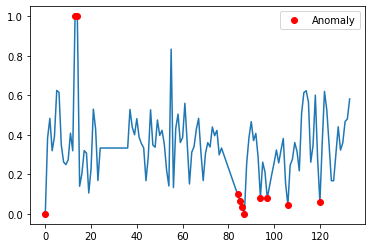

In [10]:
rd = tsod.RangeDetector(min_value=0.1, max_value=0.9)
anomalies = rd.detect(y)

plt.plot(y)
plt.plot(y[anomalies], 'ro',label='Anomaly')
plt.legend()

## strain data train & detect

In [11]:
!git clone https://github.com/changhorang/VAE_Strain.git

Cloning into 'VAE_Strain'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (341/341), done.
remote: Compressing objects: 100% (265/265), done.
remote: Total 341 (delta 174), reused 238 (delta 74), pack-reused 0
Receiving objects: 100% (341/341), 33.39 MiB | 14.28 MiB/s, done.
Resolving deltas: 100% (174/174), done.


In [27]:
!python3 ./VAE_Strain/train.py --epochs 50

Initializing Device: cuda
Start Training..
Epoch : 1/50
100% 104/104 [00:18<00:00,  5.61it/s]
Training Loss: 0.09129
Epoch : 2/50
100% 104/104 [00:18<00:00,  5.61it/s]
Training Loss: 0.04623
Epoch : 3/50
100% 104/104 [00:18<00:00,  5.61it/s]
Training Loss: 0.03933
Epoch : 4/50
100% 104/104 [00:18<00:00,  5.61it/s]
Training Loss: 0.03077
Epoch : 5/50
100% 104/104 [00:18<00:00,  5.61it/s]
Training Loss: 0.02525
Epoch : 6/50
100% 104/104 [00:18<00:00,  5.61it/s]
Training Loss: 0.02068
Epoch : 7/50
100% 104/104 [00:18<00:00,  5.61it/s]
Training Loss: 0.01510
Epoch : 8/50
100% 104/104 [00:18<00:00,  5.61it/s]
Training Loss: 0.01211
Epoch : 9/50
100% 104/104 [00:18<00:00,  5.61it/s]
Training Loss: 0.01048
Epoch : 10/50
100% 104/104 [00:18<00:00,  5.61it/s]
Training Loss: 0.00970
Epoch : 11/50
100% 104/104 [00:18<00:00,  5.62it/s]
Training Loss: 0.00900
Epoch : 12/50
100% 104/104 [00:18<00:00,  5.61it/s]
Training Loss: 0.00818
Epoch : 13/50
100% 104/104 [00:18<00:00,  5.61it/s]
Training Loss:

In [32]:
import numpy as np

y_list = np.loadtxt('y_list.csv', delimiter=',')
y_list = y_list.T
y_list = pd.Series(y_list)
print(y_list)

0       0.689936
1       0.703396
2       0.720040
3       0.723535
4       0.721761
          ...   
8795    0.734022
8796    0.669119
8797    0.620024
8798    0.621537
8799    0.671101
Length: 8800, dtype: float64


Text(0.5, 1.0, 'predict value')

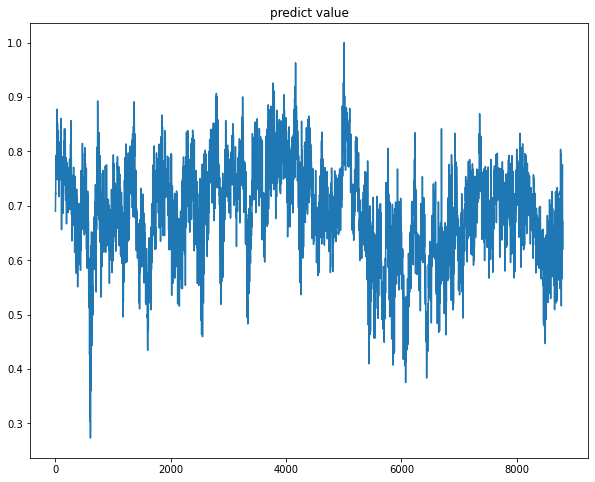

In [53]:
plt.figure(figsize=(10, 8))
plt.plot(y_list)
plt.title('predict value')

In [49]:
def get_outlier(df=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df.values, 25)
  quantile_75 = np.percentile(df.values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight

  return lowest, highest

In [50]:
lowest, highest = get_outlier(y_list)

rd = tsod.RangeDetector(min_value=lowest, max_value=highest)
anomalies = rd.detect(y_list)

y_list[anomalies]

591     0.436427
592     0.426201
593     0.441279
597     0.396254
598     0.329420
          ...   
6453    0.452966
6454    0.448479
6459    0.432723
6460    0.440549
8496    0.446757
Length: 96, dtype: float64

In [51]:
anomalies

0       False
1       False
2       False
3       False
4       False
        ...  
8795    False
8796    False
8797    False
8798    False
8799    False
Length: 8800, dtype: bool

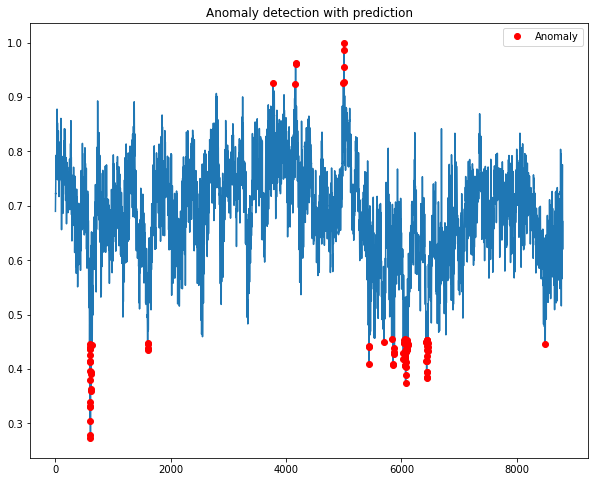

In [52]:
plt.figure(figsize=(10, 8))
plt.plot(y_list)
plt.plot(y_list[anomalies], 'ro',label='Anomaly')
plt.title('Anomaly detection with prediction')
plt.legend()